The Notebook has a approach for finding Similar users where the problem formulation goes as follows: Similar users watch courses with similar difficulty level. For instance, if a user X1 watched a course Y1 with difficulty level beginner, so she/he will be similar to User X2 who watched the same course Y1. So, if we can create such a Neural Network which can figure out a target level for a particular user based on User-Course viewing interaction with User Embedding layer, we can utlizing that layer to find similar users in the Embedding space.

In [21]:
NUM_SIMILAR_USERS=10
RANDOM_STATE=101

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import heapq

In [24]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
import tensorflow as tf

In [27]:
current_time=datetime.now().strftime("%Y%m%d-%H%M%S")

In [28]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [29]:
LOG_DIR=nb_dir+ "/logs/fit/" + current_time
MODEL_NAME='dnn'

# Data Ingestion

In [30]:
from paths import course_tags_file, user_assessment_scores_file, user_course_views_file, interests_file

In [31]:
file_paths=[course_tags_file, user_assessment_scores_file, user_course_views_file, interests_file]
file_paths

['/Users/skumar/projects/personal/pluralsight-recommender/data/raw/course_tags.csv',
 '/Users/skumar/projects/personal/pluralsight-recommender/data/raw/user_assessment_scores.csv',
 '/Users/skumar/projects/personal/pluralsight-recommender/data/raw/user_course_views.csv',
 '/Users/skumar/projects/personal/pluralsight-recommender/data/raw/user_interests.csv']

In [32]:
course_tags_df=pd.read_csv(file_paths[0])
user_assessment_scores_df=pd.read_csv(file_paths[1])
user_course_views_df=pd.read_csv(file_paths[2])
user_interests_df=pd.read_csv(file_paths[3])

In [33]:
user_course_views_df=user_course_views_df[user_course_views_df.view_time_seconds>0]

In [34]:
course_level_dict=dict(zip(user_course_views_df.course_id, user_course_views_df.level))

In [35]:
user_idx_dict={}
course_idx_dict={}

for idx, user in enumerate(user_course_views_df.user_handle.unique()):
    if user not in user_idx_dict:
        user_idx_dict[user]=idx
        
for idx, course in enumerate(course_tags_df.course_id.unique()):
    if course not in course_idx_dict:
        course_idx_dict[course]=idx

In [36]:
processed_user_interests_df=user_interests_df.groupby(['user_handle'])['interest_tag'].apply(lambda x: ','.join(x)).reset_index()

In [40]:
processed_user_interests_df['user']=processed_user_interests_df['user_handle'].map(user_idx_dict)

In [42]:
total_view_time_df=user_course_views_df.groupby(['user_handle', 'course_id']).agg({'view_time_seconds':'sum'}).reset_index()

In [43]:
total_view_time_df=total_view_time_df[total_view_time_df.view_time_seconds>0]

In [44]:
total_view_time_df.head()

,user_handle,course_id,view_time_seconds
0,1,aws-certified-solutions-architect-professional,102
1,1,aws-certified-sysops-admin-associate,83
2,1,aws-system-admin-fundamentals,2665
3,1,cpt-sp2010-web-designers-branding-intro,4884
4,1,cpt-sp2010-web-designers-css,4959


In [45]:
total_view_time_df['user']=total_view_time_df['user_handle'].map(user_idx_dict)
total_view_time_df['course']=total_view_time_df['course_id'].map(course_idx_dict)
reverse_user_dict={val:key for key,val in user_idx_dict.items()}
reverse_course_idx_dict={val:key for key, val in course_idx_dict.items()}

In [46]:
total_view_time_df.head()

,user_handle,course_id,view_time_seconds,user,course
0,1,aws-certified-solutions-architect-professional,102,0,587
1,1,aws-certified-sysops-admin-associate,83,0,588
2,1,aws-system-admin-fundamentals,2665,0,607
3,1,cpt-sp2010-web-designers-branding-intro,4884,0,1279
4,1,cpt-sp2010-web-designers-css,4959,0,1281


In [47]:
total_view_time_df['level']=total_view_time_df['course_id'].map(course_level_dict)

In [48]:
total_view_time_df.head()

,user_handle,course_id,view_time_seconds,user,course,level
0,1,aws-certified-solutions-architect-professional,102,0,587,Advanced
1,1,aws-certified-sysops-admin-associate,83,0,588,Intermediate
2,1,aws-system-admin-fundamentals,2665,0,607,Beginner
3,1,cpt-sp2010-web-designers-branding-intro,4884,0,1279,Beginner
4,1,cpt-sp2010-web-designers-css,4959,0,1281,Intermediate


In [49]:
num_users=total_view_time_df.user.max()
num_courses=total_view_time_df.course.max()

## Approx number of embeddings to start with

This is an emprical process to experiment with different number of embeddings but 4th root of input is considered a good starting point. Reference: https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture

In [50]:
num_users**(1/4)

9.67416814660946

In [51]:
num_courses**(1/4)

8.779401043930761

In [52]:
total_view_time_df.head()

,user_handle,course_id,view_time_seconds,user,course,level
0,1,aws-certified-solutions-architect-professional,102,0,587,Advanced
1,1,aws-certified-sysops-admin-associate,83,0,588,Intermediate
2,1,aws-system-admin-fundamentals,2665,0,607,Beginner
3,1,cpt-sp2010-web-designers-branding-intro,4884,0,1279,Beginner
4,1,cpt-sp2010-web-designers-css,4959,0,1281,Intermediate


In [53]:
target_map_dict={
    'Advanced':2,
    'Intermediate':1,
    'Beginner':0
}
modified_df=total_view_time_df.copy()
modified_df['target']=total_view_time_df['level'].map(target_map_dict)

# Train Test Split

In [54]:
modified_df.target.value_counts()

1    50224
0    47893
2     7207
Name: target, dtype: int64

As there is an imbalance in the target class, so we will use stratified splits for train, test and val sets to make sure they are have the same ratio of all the classes

In [55]:
input_df=modified_df[['user', 'course','target']]

train, test = train_test_split(input_df, test_size=0.1, random_state=RANDOM_STATE,stratify=input_df.target)
train, val = train_test_split(train, test_size=0.1, random_state=RANDOM_STATE,stratify=train.target)

In [56]:
train.target.value_counts().min()/train.target.value_counts().max()

0.14348221528477667

In [57]:
val.target.value_counts().min()/val.target.value_counts().max()

0.14358407079646018

In [58]:
test.target.value_counts().min()/test.target.value_counts().max()

0.1435397173004181

## Keras Callbacks

In [59]:
checkpoint_path = nb_dir+'/generator/models/'+f"trained_{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [60]:
class TrainStopCallback(tf.keras.callbacks.Callback):
    def __init__(self, expected_accuracy):
        self.expected_accuracy=expected_accuracy
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>self.expected_accuracy:
            print(f"\n Training will stop because expected training accuracy {self.expected_accuracy} is acheived")
            self.model.stop_training=True

class ModelCheckPoint:     
    def save(self, checkpoint_path):
        model_cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path  , monitor='val_loss', save_best_only=True)
        return model_cp_callback

train_stop_callback=TrainStopCallback(expected_accuracy=.999)   
cp_callback=ModelCheckPoint().save(checkpoint_path)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

In [61]:
def plot_metric(history, attr='accuracy'):
    pd.Series(history.history[attr]).plot()
    pd.Series(history.history[f"val_{attr}"]).plot()
    plt.xlabel("Epoch")
    plt.ylabel(f"Train/Validation {attr}")

# Deep Neural Network Classifier

## Iteration 1

In [62]:
def build_model_1(reg=0.01, embedding_size=10, optimizer='adam', metric='accuracy'):
    user=tf.keras.layers.Input(shape=(1,))
    course=tf.keras.layers.Input(shape=(1,))
    user_emb=tf.keras.layers.Embedding(num_users+1, embedding_size, name='user_embedding', 
                                      embeddings_regularizer=tf.keras.regularizers.l2(reg))(user) #(N,1,k)
    user_emb=tf.keras.layers.Flatten()(user_emb)
    course_emb=tf.keras.layers.Embedding(num_courses+1, embedding_size, name='course_embedding',
                                        embeddings_regularizer=tf.keras.regularizers.l2(reg))(course) #(N,1,k)
    course_emb=tf.keras.layers.Flatten()(course_emb)
    concat=tf.keras.layers.concatenate([user_emb, course_emb], name='concat') # (2N,1,1)
    x=tf.keras.layers.Flatten()(concat)
    x=tf.keras.layers.Dense(3, activation='softmax')(x)
    model=tf.keras.Model(inputs=[user, course], outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.01),
                 metrics=['accuracy'])
    return model   

model_1=build_model_1()

history_1=model_1.fit(x=[train.user, train.course], 
                  y=train.target, 
                  validation_data=([val.user, val.course],
                                  val.target), 
            batch_size=128, shuffle=True,
            epochs=50, verbose=1,
            callbacks=[cp_callback, tensorboard_callback, train_stop_callback])

Train on 85311 samples, validate on 9480 samples
Epoch 1/50
84224/85311 [============================>.] - ETA: 0s - loss: 0.8908 - accuracy: 0.8083WARNING:tensorflow:From /Users/skumar/projects/personal/pluralsight-recommender/venv/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/skumar/projects/personal/pluralsight-recommender/generator/models/trained_dnn/cp.ckpt/assets
85311/85311 [==============================] - 2s 26us/sample - loss: 0.8912 - accuracy: 0.8089 - val_loss: 0.9196 - val_accuracy: 0.8621
Epoch 2/50
85311/85311 [==============================] - 2s 21us/sample - loss: 0.9093 - accuracy: 0.8771 - val_loss: 0.9168 - val_accuracy: 0.8870
Epoch 3/50
85311/8

85311/85311 [==============================] - 1s 12us/sample - loss: 1.2796 - accuracy: 0.9943 - val_loss: 1.3044 - val_accuracy: 0.9910
Epoch 48/50
85311/85311 [==============================] - 1s 13us/sample - loss: 1.2717 - accuracy: 0.9946 - val_loss: 1.4012 - val_accuracy: 0.9918
Epoch 49/50
85311/85311 [==============================] - 1s 13us/sample - loss: 1.2903 - accuracy: 0.9945 - val_loss: 1.3745 - val_accuracy: 0.9920
Epoch 50/50
85311/85311 [==============================] - 1s 12us/sample - loss: 1.3057 - accuracy: 0.9946 - val_loss: 1.4577 - val_accuracy: 0.9935


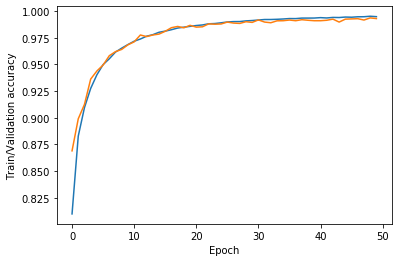

In [318]:
plot_metric(history_1)

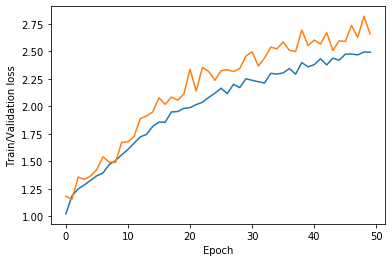

In [319]:
plot_metric(history, attr='loss')

In [320]:
results_1=model_1.evaluate([test.user,test.course], test.target)

10533/10533 [==============================] - 0s 30us/sample - loss: 1.3787 - accuracy: 0.9932


The model does not look very confident(looking at the loss) on it's predictions as the probabilities of all the classes is pretty close. Let's see if we can improve by adding a few hidden layer. Also, let's analyse the performance more closely

In [321]:
test_predictions_1=model_1.predict([test.user,test.course])

In [322]:
test_predictions_1

array([[1.6233985e-03, 9.9529332e-01, 3.0833040e-03],
       [9.7654939e-01, 1.4784191e-02, 8.6664176e-03],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       ...,
       [9.9964690e-01, 2.6313282e-04, 9.0003268e-05],
       [1.2548994e-04, 9.9971861e-01, 1.5592175e-04],
       [2.2880241e-10, 9.9999976e-01, 2.1900536e-07]], dtype=float32)

In [323]:
test_predictions_1=[np.argmax(prediction) for prediction in test_predictions_1]

In [301]:
test["predicted_1"]=test_predictions_1

/Users/skumar/projects/personal/pluralsight-recommender/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [302]:
test[test.target==test.predicted_1].shape[0]/test.shape[0]

0.9936390392101015

In [63]:
test.head()

,user,course,target
88178,7261,1851,1
10696,900,2903,0
32648,2765,97,1
14263,1205,2165,0
1122,84,2811,1


## Iteration 2

In [65]:
def build_model_2(reg=0.01, embedding_size=10, optimizer='adam', metric='accuracy'):
    user=tf.keras.layers.Input(shape=(1,))
    course=tf.keras.layers.Input(shape=(1,))
    user_emb=tf.keras.layers.Embedding(num_users+1, embedding_size, name='user_embedding', 
                                      embeddings_regularizer=tf.keras.regularizers.l2(reg))(user) #(N,1,k)
    user_emb=tf.keras.layers.Flatten()(user_emb)
    course_emb=tf.keras.layers.Embedding(num_courses+1, embedding_size, name='course_embedding',
                                        embeddings_regularizer=tf.keras.regularizers.l2(reg))(course) #(N,1,k)
    course_emb=tf.keras.layers.Flatten()(course_emb)
    concat=tf.keras.layers.concatenate([user_emb, course_emb], name='concat') # (2N,1,1)
    x=tf.keras.layers.Flatten()(concat)
    x=tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(x)
    x=tf.keras.layers.Dense(3, activation='softmax')(x)
    model=tf.keras.Model(inputs=[user, course], outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
                 metrics=[metric])
    return model   

model_2=build_model_2()

history_2=model_2.fit(x=[train.user, train.course], 
                  y=train.target, 
                  validation_data=([val.user, val.course],
                                  val.target), 
            batch_size=128, shuffle=True,
            epochs=50, verbose=1,
            callbacks=[cp_callback, tensorboard_callback, train_stop_callback])

Train on 85311 samples, validate on 9480 samples
Epoch 1/50
85311/85311 [==============================] - 2s 26us/sample - loss: 0.8566 - accuracy: 0.7901 - val_loss: 0.6222 - val_accuracy: 0.9114
Epoch 2/50
85311/85311 [==============================] - 2s 19us/sample - loss: 0.5593 - accuracy: 0.9149 - val_loss: 0.5174 - val_accuracy: 0.9181
Epoch 3/50
85311/85311 [==============================] - 2s 18us/sample - loss: 0.4836 - accuracy: 0.9206 - val_loss: 0.4605 - val_accuracy: 0.9209
Epoch 4/50
85311/85311 [==============================] - 2s 18us/sample - loss: 0.4376 - accuracy: 0.9234 - val_loss: 0.4209 - val_accuracy: 0.9252
Epoch 5/50
85311/85311 [==============================] - 2s 18us/sample - loss: 0.4029 - accuracy: 0.9255 - val_loss: 0.3920 - val_accuracy: 0.9246
Epoch 6/50
85311/85311 [==============================] - 2s 18us/sample - loss: 0.3746 - accuracy: 0.9270 - val_loss: 0.3640 - val_accuracy: 0.9263
Epoch 7/50
85311/85311 [==============================] -

Epoch 23/50
85311/85311 [==============================] - 2s 18us/sample - loss: 0.1994 - accuracy: 0.9934 - val_loss: 0.2063 - val_accuracy: 0.9851
Epoch 24/50
85311/85311 [==============================] - 2s 21us/sample - loss: 0.1947 - accuracy: 0.9944 - val_loss: 0.2020 - val_accuracy: 0.9858
Epoch 25/50
85311/85311 [==============================] - 2s 18us/sample - loss: 0.1913 - accuracy: 0.9946 - val_loss: 0.1983 - val_accuracy: 0.9857
Epoch 26/50
85311/85311 [==============================] - 2s 19us/sample - loss: 0.1877 - accuracy: 0.9948 - val_loss: 0.1972 - val_accuracy: 0.9869
Epoch 27/50
85311/85311 [==============================] - 2s 18us/sample - loss: 0.1843 - accuracy: 0.9949 - val_loss: 0.1928 - val_accuracy: 0.9859
Epoch 28/50
85311/85311 [==============================] - 2s 18us/sample - loss: 0.1820 - accuracy: 0.9949 - val_loss: 0.1901 - val_accuracy: 0.9874
Epoch 29/50
85311/85311 [==============================] - 2s 19us/sample - loss: 0.1775 - accuracy:

Epoch 47/50
85311/85311 [==============================] - 1s 12us/sample - loss: 0.1443 - accuracy: 0.9960 - val_loss: 0.1574 - val_accuracy: 0.9883
Epoch 48/50
85311/85311 [==============================] - 1s 13us/sample - loss: 0.1440 - accuracy: 0.9961 - val_loss: 0.1562 - val_accuracy: 0.9881
Epoch 49/50
85311/85311 [==============================] - 2s 19us/sample - loss: 0.1415 - accuracy: 0.9959 - val_loss: 0.1540 - val_accuracy: 0.9882
Epoch 50/50
85311/85311 [==============================] - 1s 14us/sample - loss: 0.1394 - accuracy: 0.9965 - val_loss: 0.1549 - val_accuracy: 0.9890


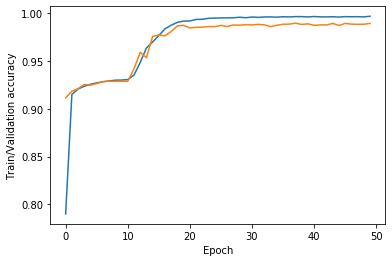

In [68]:
plot_metric(history_2)

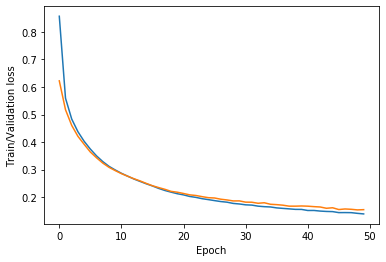

In [69]:
plot_metric(history_2, attr='loss')

In [70]:
results_2=model_2.evaluate([test.user,test.course], test.target)

10533/10533 [==============================] - 0s 23us/sample - loss: 0.1542 - accuracy: 0.9875


So, loss reduced from 1.6080 to 0.1582 but the accuracy on unseen data decreased a little but it is not that bad. I will consider we are moving in the right direction.

In [71]:
test_predictions_2=model_2.predict([test.user,test.course])

In [72]:
test_predictions_2

array([[2.2557590e-06, 9.9329126e-01, 6.7065223e-03],
       [9.9065596e-01, 1.4112389e-06, 9.3425876e-03],
       [1.6418961e-05, 9.8121095e-01, 1.8772639e-02],
       ...,
       [9.6658051e-01, 2.0769399e-05, 3.3398826e-02],
       [2.9753335e-07, 9.9766147e-01, 2.3381240e-03],
       [7.8433504e-06, 9.8718125e-01, 1.2810833e-02]], dtype=float32)

One way to speed up the model training will be to add Batch Normalization. Let's see how it works

# Iteration 3

In [73]:
def build_model_3(reg=0.01, embedding_size=10, optimizer='adam', metric='accuracy'):
    user=tf.keras.layers.Input(shape=(1,))
    course=tf.keras.layers.Input(shape=(1,))
    user_emb=tf.keras.layers.Embedding(num_users+1, embedding_size, name='user_embedding', 
                                      embeddings_regularizer=tf.keras.regularizers.l2(reg))(user) #(N,1,k)
    user_emb=tf.keras.layers.Flatten()(user_emb)
    course_emb=tf.keras.layers.Embedding(num_courses+1, embedding_size, name='course_embedding',
                                        embeddings_regularizer=tf.keras.regularizers.l2(reg))(course) #(N,1,k)
    course_emb=tf.keras.layers.Flatten()(course_emb)
    concat=tf.keras.layers.concatenate([user_emb, course_emb], name='concat') # (2N,1,1)
    x=tf.keras.layers.Flatten()(concat)
    x=tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dense(3, activation='softmax')(x)
    model=tf.keras.Model(inputs=[user, course], outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
                 metrics=[metric])
    return model   

model_3=build_model_3()

history_3=model_3.fit(x=[train.user, train.course], 
                  y=train.target, 
                  validation_data=([val.user, val.course],
                                  val.target), 
            batch_size=128, shuffle=True,
            epochs=50, verbose=1,
            callbacks=[cp_callback, tensorboard_callback, train_stop_callback])

Train on 85311 samples, validate on 9480 samples
Epoch 1/50
85311/85311 [==============================] - 3s 30us/sample - loss: 0.3495 - accuracy: 0.9359 - val_loss: 0.1455 - val_accuracy: 0.9914
Epoch 2/50
85311/85311 [==============================] - 2s 22us/sample - loss: 0.0958 - accuracy: 0.9963 - val_loss: 0.1045 - val_accuracy: 0.9945
Epoch 3/50
85311/85311 [==============================] - 2s 23us/sample - loss: 0.0890 - accuracy: 0.9963 - val_loss: 0.0903 - val_accuracy: 0.9937
Epoch 4/50
85311/85311 [==============================] - 1s 14us/sample - loss: 0.0763 - accuracy: 0.9971 - val_loss: 0.0906 - val_accuracy: 0.9927
Epoch 5/50
85311/85311 [==============================] - 2s 26us/sample - loss: 0.0644 - accuracy: 0.9977 - val_loss: 0.0811 - val_accuracy: 0.9930
Epoch 6/50
85311/85311 [==============================] - 2s 23us/sample - loss: 0.0541 - accuracy: 0.9987 - val_loss: 0.0539 - val_accuracy: 0.9955
Epoch 7/50
85311/85311 [==============================] -

In [74]:
results_3=model_3.evaluate([test.user,test.course], test.target)

10533/10533 [==============================] - 0s 24us/sample - loss: 0.0418 - accuracy: 0.9958


So, loss reduced from 0.1582 to 0.0828 and accuracy on the unseen data also increased from 0.9872 to 0.9958

Also, this worked better than expected. Accuracy improved, loss dropped and model stopped training in only 3 iterations 

In [75]:
test_predictions_3=model_3.predict([test.user,test.course])

In [76]:
test_predictions_3=[np.argmax(prediction) for prediction in test_predictions_3]

In [77]:
test["predicted_3"]=test_predictions_3

# Qualitative Assesment: Sanity Check for Predictions

In [84]:
def predict_similar_users(user_handle, model, num_similar_users=NUM_SIMILAR_USERS): 
    user=user_idx_dict[user_handle]
    user_layer=model.get_layer('user_embedding')
    user_weights=user_layer.get_weights()[0]
    user_lengths=np.linalg.norm(user_weights, axis=1)
    noramlized_users=(user_weights.T/user_lengths).T
    dists=np.dot(noramlized_users, noramlized_users[user])
    dists=dists[~np.isnan(dists) & ~np.isinf(dists)]
    similar_users = []
    for user_idx, score in enumerate(dists):
        if user_idx != user:
            similar_users.append((user_idx, score))
    k_neighbors = heapq.nlargest(
        num_similar_users, similar_users, key=lambda t: t[1]
    )
    data = [
    (reverse_user_dict[user[0]], user[1])
    for user in k_neighbors
    ]
    return pd.DataFrame(data, columns=["similar_users", "course_level_sim_score"])

In [85]:
user_handle=299
similar_users=predict_similar_users(user_handle, model_3)

In [86]:
similar_users.loc[-1] = [user_handle, 1] 
similar_users.index = similar_users.index + 1 
similar_users = similar_users.sort_index()
similar_users.sort_values(by=['course_level_sim_score'], ascending=False)

,similar_users,course_level_sim_score
0,299,1.000000
1,294,1.000000
2,1206,0.966051
3,9273,0.960215
4,2931,0.932379
5,5413,0.929772
6,1273,0.909393
7,5328,0.909174
8,7392,0.908865
9,9239,0.908171


In [87]:
processed_user_interests_df.merge(similar_users, left_on='user_handle', right_on='similar_users').sort_values(by='course_level_sim_score', ascending=False)[['user_handle', 'interest_tag','course_level_sim_score']]

,user_handle,interest_tag,course_level_sim_score
0,294,"java,design-patterns,python,react.js,nodejs,ht...",1.000000
1,299,"design-patterns,javascript-frameworks,javascri...",1.000000
2,1206,"java,data-analysis,nodejs",0.966051
10,9273,"maya,zbrush,3d-texturing,3d-animation,pipeline...",0.960215
5,2931,"rapid-application-development,rapid-applicatio...",0.932379
7,5413,"big-data,sql,ssis,data-visualization,business-...",0.929772
3,1273,"typescript,python",0.909393
6,5328,"network-infrastructure,cloud-computing,server-...",0.909174
8,7392,"c#,javascript-frameworks,javascript-libraries,...",0.908865
9,9239,"server-infrastructure,devops,it-fundamentals,s...",0.908171


Users choosen by the algorithm seem to have shown interest in similar tags